# Hyperparameter Search

In [171]:
from typing import List
import pandas as pd
from pandas import DataFrame
import numpy as np
import re
import matplotlib.pyplot as plt
from IPython.core.display import display
from matplotlib.axes import Axes

In [172]:
# results.csv has missing column headers for some fields

def df_autocast(df: DataFrame) -> DataFrame:
    for col in df.columns:
        if   re.match(r'^[+-]?\d+$',           str(df[col].iloc[-1])): df[col] = df[col].astype(int) 
        elif re.match(r'^([+-]?e?\d+)*\.\d+$', str(df[col].iloc[-1])): df[col] = df[col].astype(float)
    return df

def results_csv(filename: str) -> DataFrame:
    if not '.csv' in filename:
        filename = f'../data_output/submissions/{filename}/results.csv'
        
    df = pd.read_csv(
        filename,
        names=['time','epochs','val_loss','val_grapheme_root_accuracy','val_vowel_diacritic_accuracy','val_consonant_diacritic_accuracy','file','patience',''],
        skiprows=1,
        index_col=False,
    ).infer_objects()
    
    df_hparams = df['file'].str.extract(f'(\\w+)=(\\w+)')
    for index, col in enumerate(df_hparams.columns):
        if index % 2 == 0: hparam_name     = df_hparams[col].iloc[0]
        else:              df[hparam_name] = df_hparams[col]
        
        
    df['time_min'] = (df['time'].astype(int) / 60).round(0).astype(int)
    df['val_accuracy'] = (
        df[['val_grapheme_root_accuracy','val_vowel_diacritic_accuracy', 'val_consonant_diacritic_accuracy']]
        .mean(axis=1)
    )
    df = df_autocast(df)
    df.index = [''] * len(df)
    # display(df.dtypes)
    return df
    
    
def plot_results(df: DataFrame, field: str):
    df = (
        df[[field, 'time_min','epochs', 'val_loss', 'val_grapheme_root_accuracy']]
          .sort_values(field)
    )
    display(df)

    figure, axes = plt.subplots(1, 2, figsize=(12,6))
    figure.tight_layout(pad=6.0)

    for i, cols in enumerate([['time_min','epochs'], ['val_loss', 'val_grapheme_root_accuracy']]):
        chart = plt.subplot(1,2,i+1)
        twinx: List[Axes] = [chart, chart.twinx()]
        colors  = ['r','b']
        markers = ['+', '+']
        pos     = ['upper left', 'upper right']  # TODO: figure out how to combine legend
        for j, col in enumerate(cols):
            plt.title(f'{field} vs {cols}')                        
            twinx[j].scatter(df[field],df[col], c=colors[j], marker=markers[j])
            # plt.xlabel(f'{field}')
            # plt.ylabel(f'{col}')
            # plt.ylim(0, max(df[col])*1.1)
            twinx[j].set_xlabel(field)
            twinx[j].set_ylabel(col)
            twinx[j].legend([col], loc=pos[j])
            if col in ['time_min', 'epochs']: 
                twinx[j].axis(ymin=0,ymax=max(df[cols].max())*1.2)
            else:
                twinx[j].axis(ymin=0,ymax=max(df[col])*1.2)

## Batch Size

When trained for a fixed number of `epochs=5`
- Pipeline is IO bound, so `batch_size` has little effect
- `batch_size=512` is the maximum size that will fit in local GPU memory (GTX 1060)
- `batch_size=32|64` is too small and slows the pipeline down 
- `batch_size=128` seems optimal
- `batch_size=256|512` reduces accuracy of training due to fewer backpropagation cycles

TODO: test training until convergence

Settings for hyperparameter search
```
train: {'optimizer': 'Nadam', 'epochs': 5 'learning_rate': 0.01, 'scheduler': 'plateau10'}
model: {'dense_units': 256, 'activation': 'relu', 'cnns_per_maxpool': 3, 'cnn_strides': 1, 'global_maxpool': False, 'maxpool_layers': 5, 'dropout': 0.25, 'dense_layers': 1, 'regularization': False, 'cnn_kernel': 3, 'cnn_units': 32}
transform_X: {'rescale': True, 'denoise': True, 'center': True, 'resize': 2}
transform_Y: {}
datagen: {'rotation_range': 22.5, 'cval': 0, 'height_shift_range': 0.1, 'width_shift_range': 0.1, 'shear_range': 22.5, 'fill_mode': 'constant', 'zoom_range': 0.2}
```

,batch_size,time_min,epochs,val_loss,val_grapheme_root_accuracy
,32,14,5,5.470077,0.793882
,64,13,5,3.139174,0.853880
,128,12,5,1.813379,0.845738
,256,12,5,2.784541,0.758904
,512,12,5,9.516379,0.305697


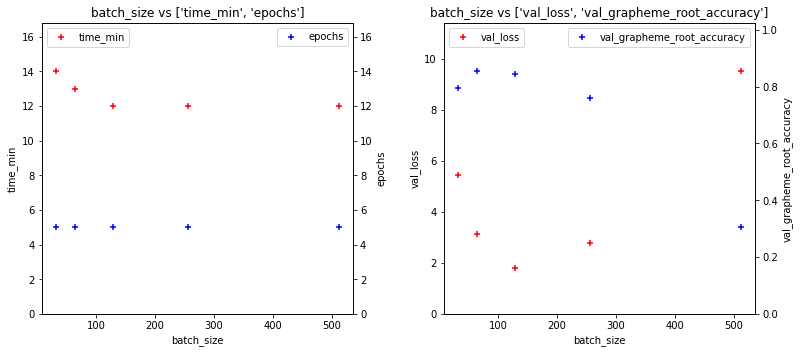

In [173]:
batch_size = results_csv('image_data_generator_cnn_search__batch').sort_values('batch_size')
plot_results(batch_size,'batch_size')

## Patience

Results:
- Both `time` and `epochs` increase linearly with `patience`
- `val_loss` drops exponentially with `patience`
- `patience=32` (297 min) increases both `val_loss` and `accuracy` so is on the verge of overfitting
- `patience=16+` (176 min) shows large spikes in `epoch_loss` in tensorboard 
- `patience=8`   (134 min) has nearly best `val_loss` and should be used for final training 
- `patience=6`   (109 min) this is almost perfect timing for Kaggle Kernels (2h time limit)
- `patience=5`   ( 75 min) odd values of patience have weird results due to: ReduceLRonPlateau(patience/2) 
- `patience=4`   ( 83 min) produces nearly optimal results in a shorter timeframe
- `patience=3`   ( 65 min) produces no better results than `patience=2` due to being an odd number   
- `patience=2`   ( 38 min) produces possibly acceptable results for hyperparameter search 
- `patience=1`   ( 31 min) has worse results and doesn't save much time compared `patience=2`
- `patience=0`   ( 14 min) is quick, but produces suboptimal results

Conclusion:
- Use `patience=2`  for hyperparameter search 
- Use `patience=6`  for final training on Kaggle (estimated to be under 110m) 
- Use `patience=8`  for final training on localhost (kernel upload) 


TODO:
- Test with Adaldelta and min_lr
 
Settings for hyperparameter search
```/
train: { 'optimizer': 'Nadam', 'learning_rate': 0.01, 'scheduler': 'plateau10', 'batch_size': 128 }
model: {'dense_layers': 1, 'maxpool_layers': 5, 'dropout': 0.25, 'cnns_per_maxpool': 3, 'cnn_kernel': 3, 'activation': 'relu', 'cnn_units': 32, 'cnn_strides': 1, 'regularization': False, 'dense_units': 256, 'global_maxpool': False}
transform_X: {'resize': 2, 'center': True, 'denoise': True, 'rescale': True}
transform_Y: {}
datagen: {'rotation_range': 22.5, 'shear_range': 22.5, 'fill_mode': 'constant', 'cval': 0, 'zoom_range': 0.2, 'width_shift_range': 0.1, 'height_shift_range': 0.1}
```

,patience,time_min,epochs,val_loss,val_grapheme_root_accuracy
,0,14,6,1.924787,0.826721
,1,31,13,1.028538,0.912720
,2,38,16,0.746658,0.935421
,3,65,21,0.768209,0.935461
,4,83,34,0.659009,0.947271
,5,75,29,0.672724,0.943788
,6,109,41,0.647307,0.947992
,8,134,55,0.638787,0.949594
,16,176,72,0.626321,0.952636
,32,298,123,0.697025,0.955519


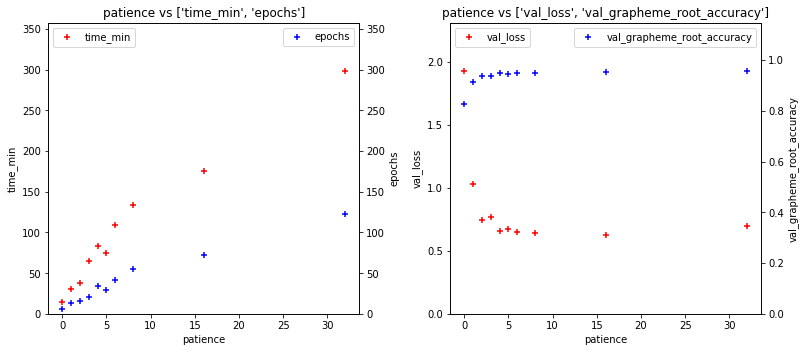

In [174]:
plot_results(results_csv('image_data_generator_cnn_search__patience'), 'patience')